In [ ]:
# This project aims to train a Convolutional Neural Network (CNN) for handwritten digit recognition 
# using PyTorch. For these purposes, we use the MNIST handwritten digit dataset. 

In [1]:
# Import the necessary libraries
import torch
#Set torch seed
torch.manual_seed(42)

import torchvision
import torchvision.transforms as transforms

# Convert the data to Tensor and normalise by the mean (0.1307) 
# and std (0.3081) of the data set
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])

# Import and normalize the train set in mini-batches of 50 images
train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_set_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                              shuffle=True)

# Import and normalize the test set in mini-batches of 50 images
test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=50,
                                              shuffle=True)

# Libraries for visualising
import matplotlib.pyplot as plt
import numpy as np

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/Users/iuniaburlan/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


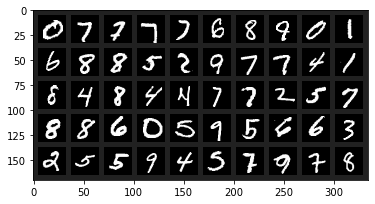

In [2]:
# Load a batch of training images for visualising
data_iterator = iter(train_set_loader)
images, labels = data_iterator.next()

# Create a visualization function 
def show_image(img):
    # revert the normalisation when displaying the images
    img = img * 0.3081 + 0.1307
    # Convert to numpy for visualisation
    npimg = img.numpy()
    # Plot each image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# Plot images as a grid using the 'make_grid' function
show_image(torchvision.utils.make_grid(images,10,5))
plt.show()

In [3]:
# Build the neural network using PyTorch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
np.random.seed(3)

class Neural_Network(nn.Module):
    
    # Define the neural network layers
    def __init__(self):
        
        super(Neural_Network, self).__init__()
        
        # Add the first convolutional layer.
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # Add the second convolutional layer.
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        
        # Add the first fully connected layer. 
        self.fc1 = nn.Linear(320, 50)
        
        # Add the second fully connected layer.  
        self.fc2 = nn.Linear(50, 10)
        
        # Costs and accuracy attributes 
        self.losses = []
        self.accuracies = []
     

    # Define the forward pass.    
    def forward(self, x):
        # Apply a 2D max pooling over the output of the 1st convolutional layer
        x = F.max_pool2d(self.conv1(x), 2)
        # Add a ReLU activation function to the 1st convolutional layer
        x = F.relu(x)
        
        # Apply a 2D max pooling over the output of the 2nd convolutional layer
        x = F.max_pool2d(self.conv2(x), 2)
        # Add a ReLU activation function to the 2nd convolutional layer
        x = F.relu(x)
        
        # Flatten the output of the 2nd convolutional layer to feed into the next layer
        x = x.view(-1, 320)
        # Add a ReLU activation function to the 1st fully connected layer
        x = F.relu(self.fc1(x))
        # Add a log softmax activation function to the final layer
        x = F.log_softmax(self.fc2(x), dim = 1) 
        
        return x
 
    
    # Train the CNN
    def train_net(self, train_set, no_epochs, lr, m):
        
        # Define the loss function as the negative log likelihood loss
        loss_func = nn.NLLLoss()

        # Define the optimizer as stochastic gradient descent
        optimizer = optim.SGD(net.parameters(), lr = lr, momentum = m)

        # Loop over the number of epochs
        for epoch in range(no_epochs):

            # Reset the current loss and accuracy to zero 
            current_loss = 0.0
            current_accuracy = 0.0
            
            # Loop over each mini-batch
            for batch_index, training_batch in enumerate(train_set, 0):
                
                # Load the mini-batch
                inputs, labels = training_batch

                # Wrap the images as Variable
                inputs, labels = Variable(inputs), Variable(labels)

                # Set the parameter gradients to zero
                optimizer.zero_grad()

                # Propagate the inputs forward
                outputs = self.forward(inputs)
                
                # Calculate loss
                loss = loss_func(outputs, labels)
                
                # Propagate backward
                loss.backward()
                
                # Update weights
                optimizer.step()

                # Add loss to the overall loss
                current_loss += loss.item()
                
                # Compute the accuracy of the current batch
                correct_pred = 0
                total_pred = 0
                for data in training_batch:
                    images, labels = training_batch
                    # Compute the predicted labels
                    outputs = self.forward(Variable(images))
                    dummy, pred_labels = torch.max(outputs.data, 1)
                    
                    # Count the correct predictions
                    correct_pred += (pred_labels == labels).sum().item()
                    total_pred += pred_labels.size(0)
                    
                # Add accuracy to the overall accuracy
                current_accuracy += (100 * correct_pred)/total_pred


                # Compute average batch loss and accuracy at every 300 batches 
                if batch_index % 300 == 299:
                    
                    # Display a message indicating where the training has reached
                    print('[Epoch: %d Batch: %5d] loss: %.3f' % 
                          (epoch + 1, batch_index+1, current_loss / 300)) 
                    # Append the average loss and accuracy
                    self.losses.append(current_loss/300)
                    self.accuracies.append(current_accuracy/300)
                    # Reset the current loss and accuracy for the next 300 batches
                    current_loss = 0.0
                    current_accuracy = 0.0


        # Display a message once the training has finished        
        print('Training has finished')

In [4]:
# Create and train a Neural Network
net = Neural_Network()

no_epochs = 5 # number of epochs
lr = 0.001 # learning rate
momentum = 0.9

# Train the network using the parameter settings above
net.train_net(train_set_loader, no_epochs, lr, momentum)

[Epoch: 1 Batch:   300] loss: 1.838
[Epoch: 1 Batch:   600] loss: 0.437
[Epoch: 1 Batch:   900] loss: 0.268
[Epoch: 1 Batch:  1200] loss: 0.206
[Epoch: 2 Batch:   300] loss: 0.169
[Epoch: 2 Batch:   600] loss: 0.151
[Epoch: 2 Batch:   900] loss: 0.127
[Epoch: 2 Batch:  1200] loss: 0.130
[Epoch: 3 Batch:   300] loss: 0.108
[Epoch: 3 Batch:   600] loss: 0.102
[Epoch: 3 Batch:   900] loss: 0.101
[Epoch: 3 Batch:  1200] loss: 0.089
[Epoch: 4 Batch:   300] loss: 0.088
[Epoch: 4 Batch:   600] loss: 0.080
[Epoch: 4 Batch:   900] loss: 0.079
[Epoch: 4 Batch:  1200] loss: 0.075
[Epoch: 5 Batch:   300] loss: 0.066
[Epoch: 5 Batch:   600] loss: 0.070
[Epoch: 5 Batch:   900] loss: 0.072
[Epoch: 5 Batch:  1200] loss: 0.066
Training has finished


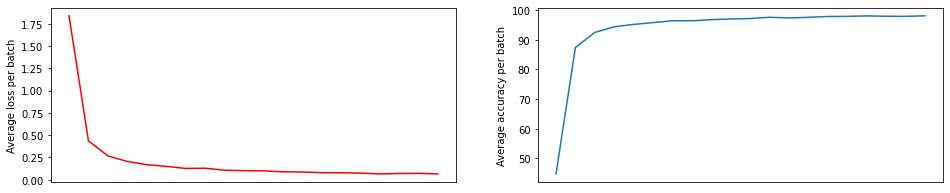

In [5]:
# Get the losses and accuracies
training_loss = net.losses
training_accuracy = net.accuracies

# Plots the loss and accuracy evolution during training 
fig = plt.figure(figsize=plt.figaspect(0.2))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(training_loss,'r')
plt.ylabel('Average loss per batch')
ax1.axes.get_xaxis().set_ticks([])
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(training_accuracy)
plt.ylabel('Average accuracy per batch')
ax1.axes.get_xaxis().set_ticks([])
plt.show()

In [6]:
# Compute classification accuracy for the test set
correct_pred = 0
total_pred = 0

for test_data in test_set_loader:
    test_images, test_labels = test_data
    # Compute the predictions
    outputs = net.forward(Variable(test_images))
    dummy, predicted_labels = torch.max(outputs.data, 1)
    # Count the correct predictions
    correct_pred += (predicted_labels == test_labels).sum()
    total_pred += predicted_labels.size(0)
       
print('Accuracy of the network on the 10,000 test images: %d %%' 
      % ( 100 * correct_pred / total_pred))

# Compute classification accuracy for each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for test_data in test_set_loader:
    test_images, test_labels = test_data
    # Compute the predictions
    outputs = net.forward(Variable(test_images))
    dummy, pred_labels = torch.max(outputs.data, 1)
    # Count the correct predictions
    correct = (pred_labels == test_labels).squeeze()
    for i in range(10):
        label = test_labels[i]
        class_correct[label] += correct[i]
        class_total[label] +=1

for i in range(10):
    print('Accuracy of digit %d : %2d %%' % ( i, 
                                             100 * class_correct[i].item()/class_total[i]))

Accuracy of the network on the 10,000 test images: 98 %
Accuracy of digit 0 : 98 %
Accuracy of digit 1 : 98 %
Accuracy of digit 2 : 98 %
Accuracy of digit 3 : 98 %
Accuracy of digit 4 : 98 %
Accuracy of digit 5 : 99 %
Accuracy of digit 6 : 97 %
Accuracy of digit 7 : 97 %
Accuracy of digit 8 : 98 %
Accuracy of digit 9 : 96 %


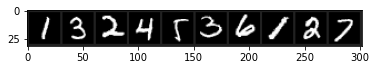

  Correct Label:      1     3     2     4     5     3     6     1     2     7
Predicted Label:      1     3     2     4     5     3     6     1     2     7


In [7]:
# Visualize an example: pick a random batch & extract the corect labels
data_iterator = iter(test_set_loader)
images, correct_labels = data_iterator.next()

# Compute the predicted label
outputs = net.forward(Variable(images))
dummy, predicted_labels = torch.max(outputs.data, 1)

show_image(torchvision.utils.make_grid(images[0:10], 10))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % correct_labels[j].item() for j in range(10)))
print('Predicted Label: ', ' '.join('%5s' % predicted_labels[j].item() for j in range(10)))